## 1. 引言

六只脚是国内著名的户外网站，拥有大量的户外GPS轨迹路线，网址为：http://www.foooooot.com/
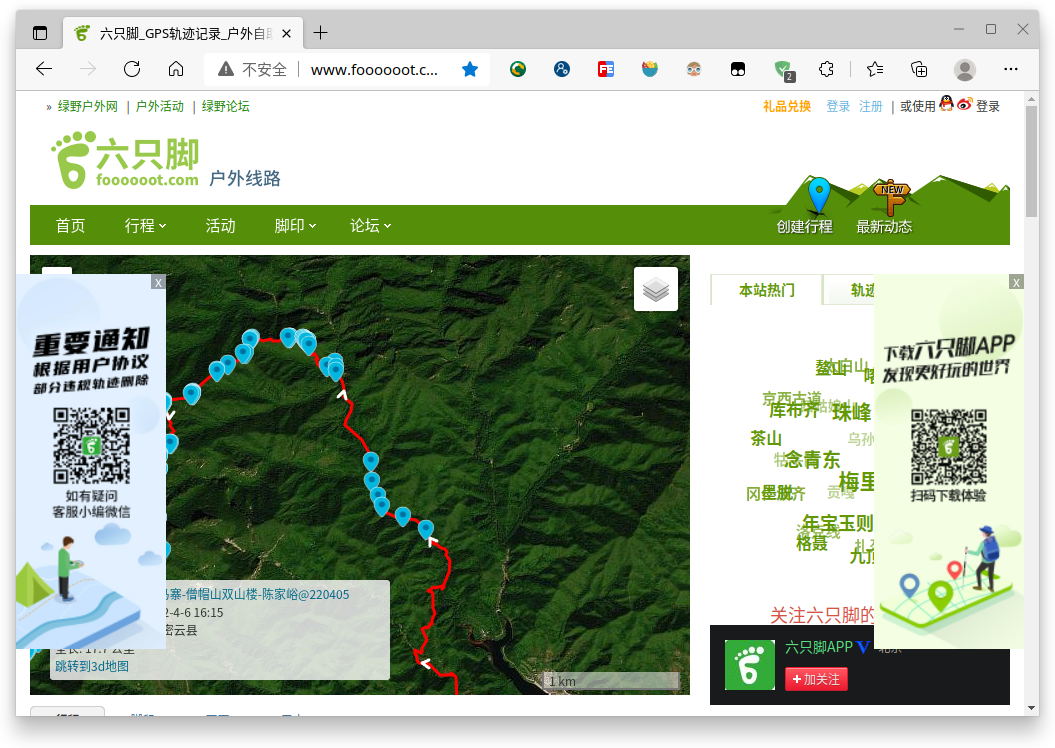

## 2. 数据分析

### 2.1 获取所有轨迹

搜索关键词`岳麓山`：

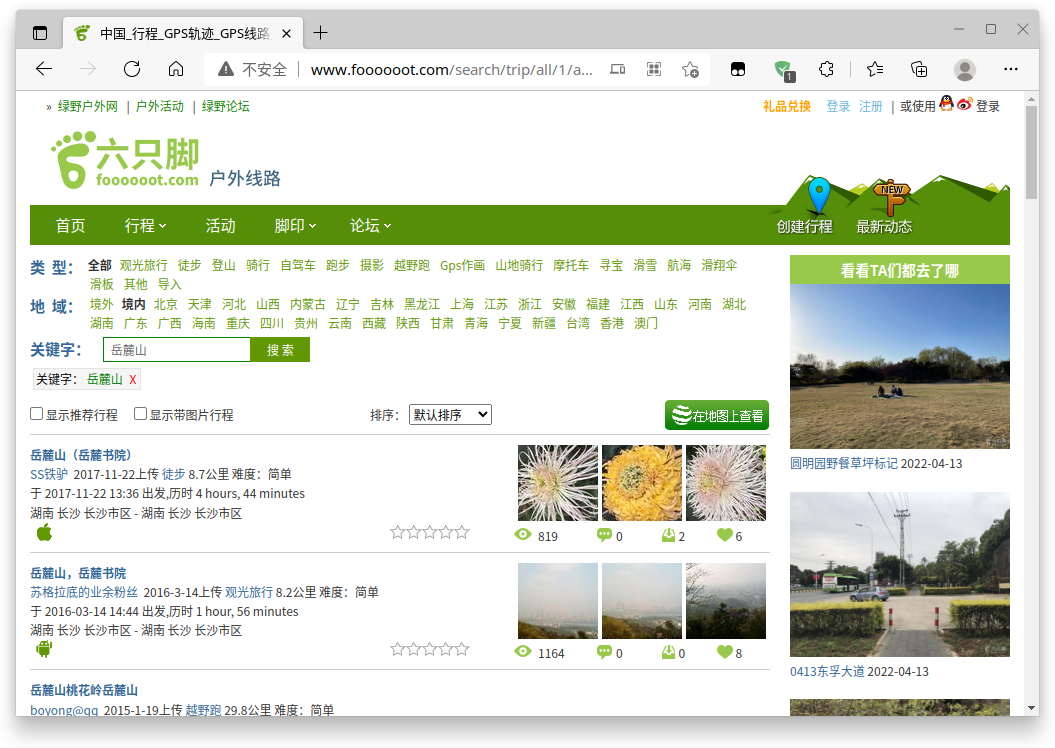

可以发现，每页具有三十个轨迹记录

观察第二页的网址我们可以发现网址为：` http://www.foooooot.com/search/trip/all/1/all/time/descent/?page=2&keyword=%E5%B2%B3%E9%BA%93%E5%B1%B1`
不难发现其规律：
- page为页数
- keyword为`岳麓山`的转义

我们不妨测试page为50的情况，在浏览器输入`http://www.foooooot.com/search/trip/all/1/all/time/descent/?page=50&keyword=%E5%B2%B3%E9%BA%93%E5%B1%B1`：

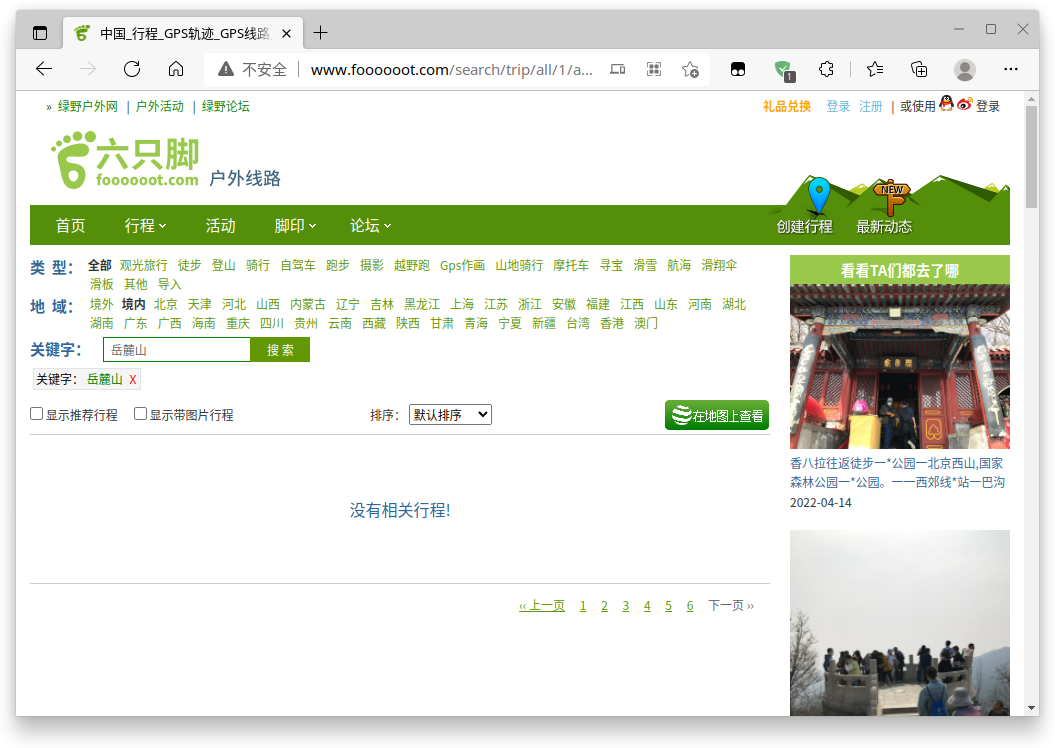

小结：我们可以通过不断增加page的数字，直至某一页不满足三十个轨迹记录，获取该关键词所有的轨迹记录


### 2.2 获取轨迹ID

点击某个具体的轨迹详情：

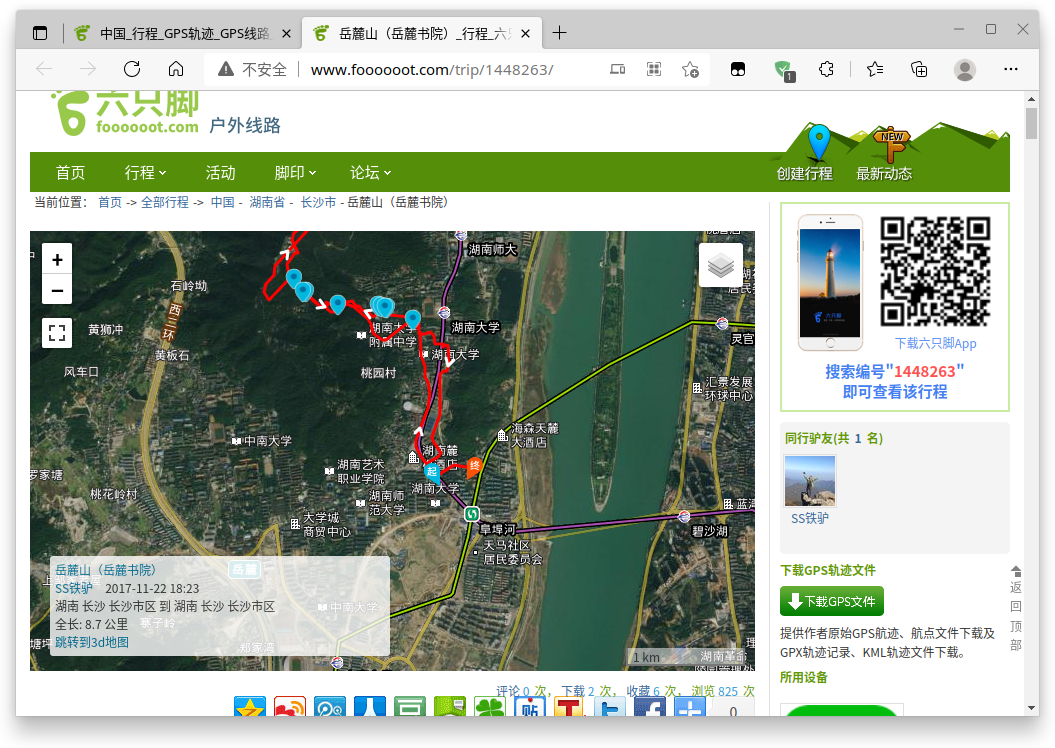

可以看到每一页具体的轨迹页面的网址是由轨迹ID构造的，诸如：`http://www.foooooot.com/trip/1448263/`

从刚才的列表界面我们就可以找到每个轨迹ID：

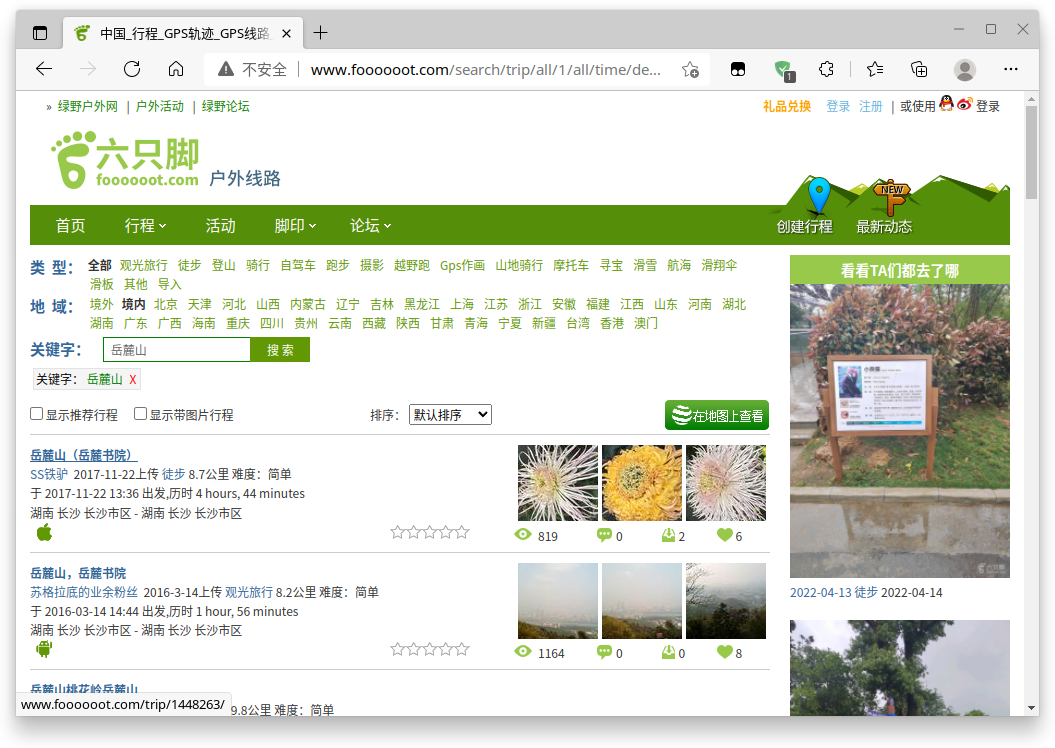


### 2.3 获取轨迹数据

我们打开浏览器控制台（按F12），点击到网络记录界面，刷新网址：

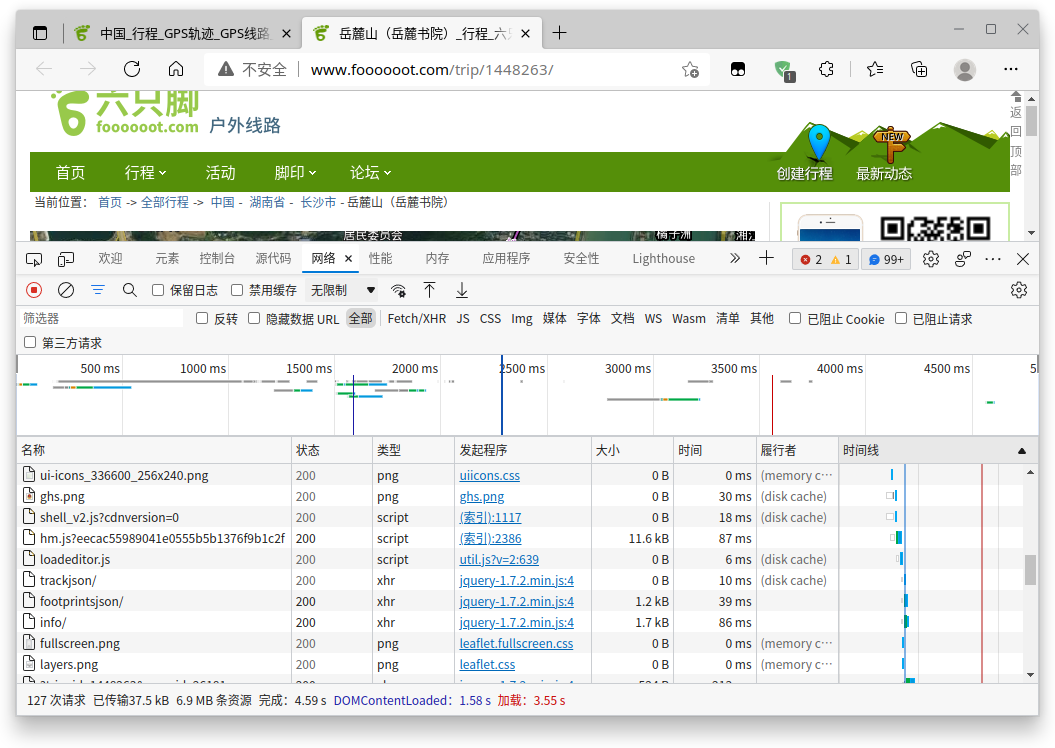

从网络请求记录中我们发现有两个XHR异步请求其名字很像轨迹数据，点开查看：

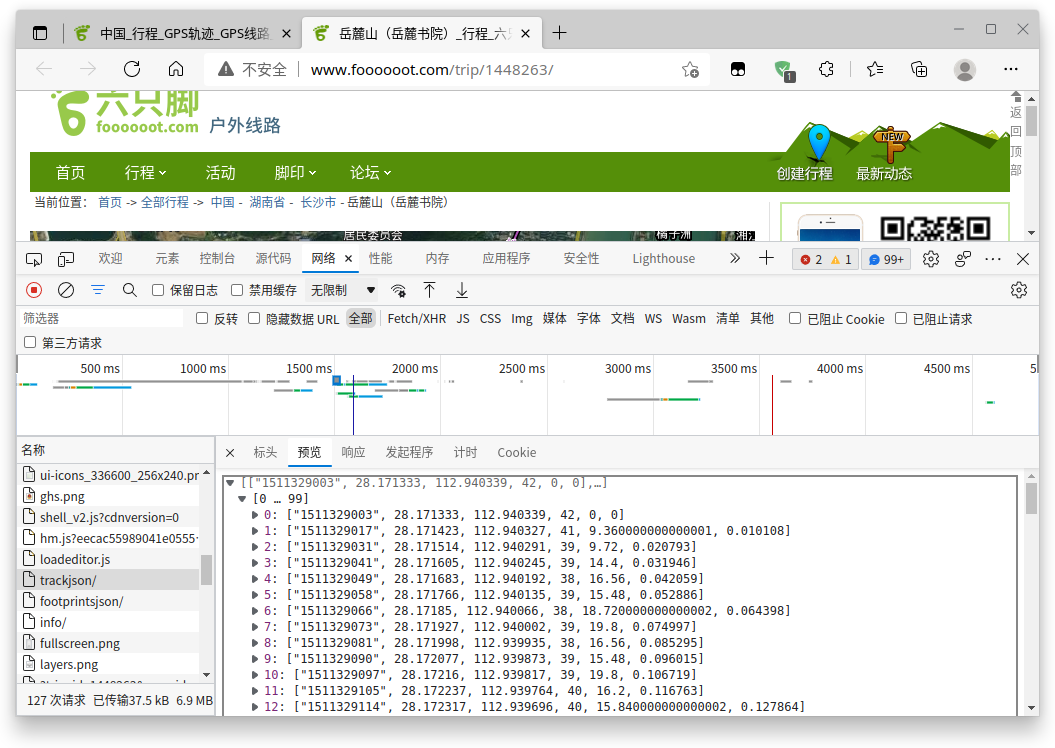

可以看到，这个trackjson就是轨迹的JSON数据：

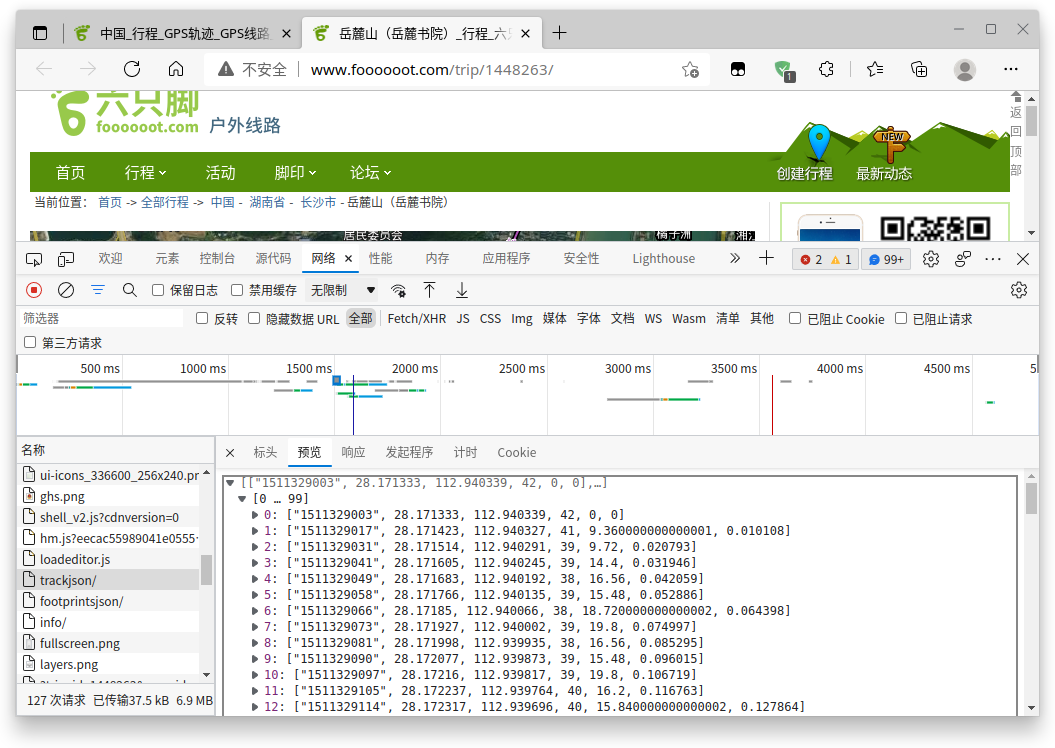

这个footprintsjson就是足迹数据，也就是拍照的那种数据：

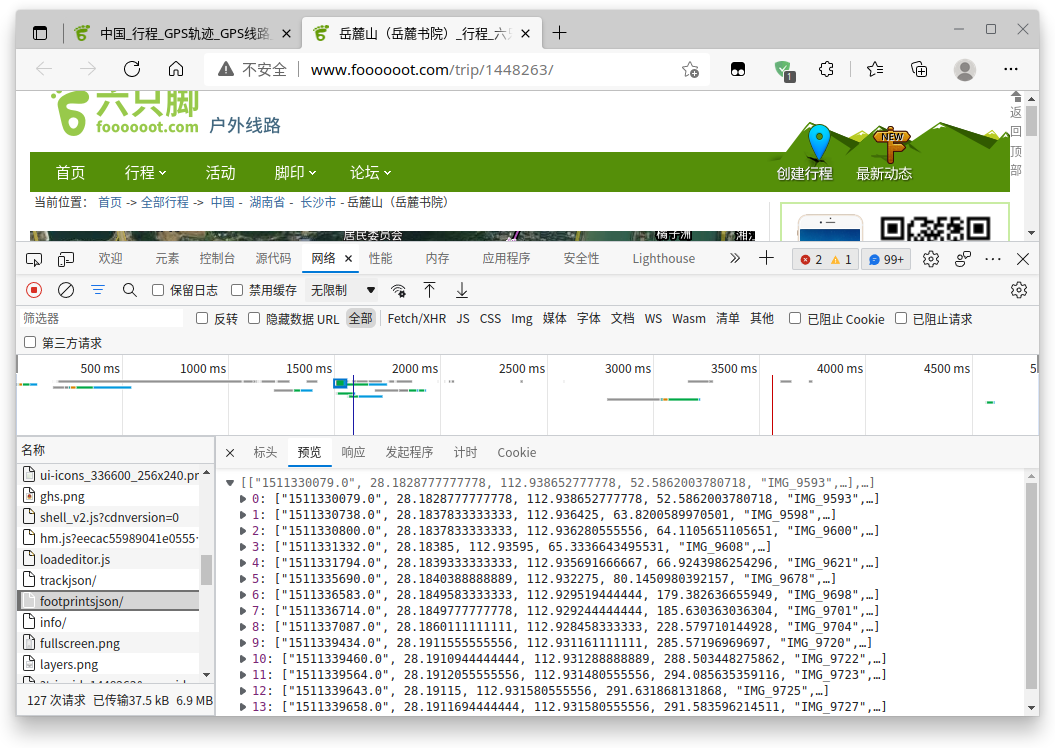

### 2.4 字段解释

对于trackjson，前三列个数据项可以快速判断为时间戳和经纬度，对于后面三个数据项，结合网页数据：

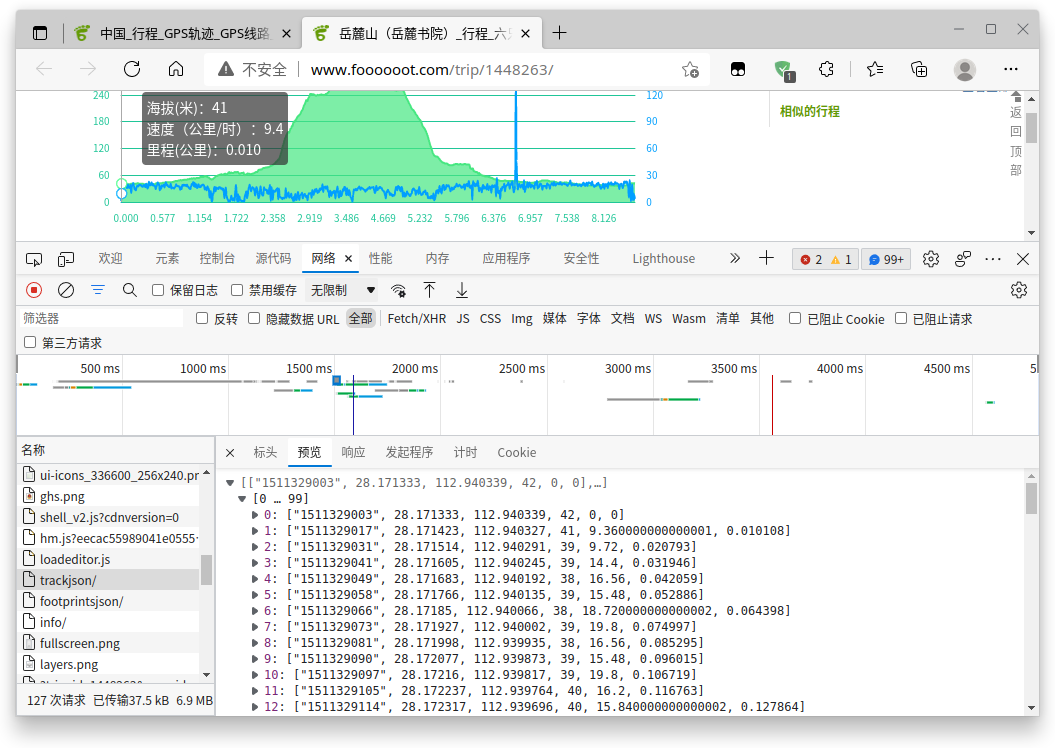

可以判断分别为高程，速度和里程

对于footprintsjson，可以判断前几列数据项分别为时间戳、经纬度、高程、名字、缩略图、详情图，后面几项笔者认为没啥作用

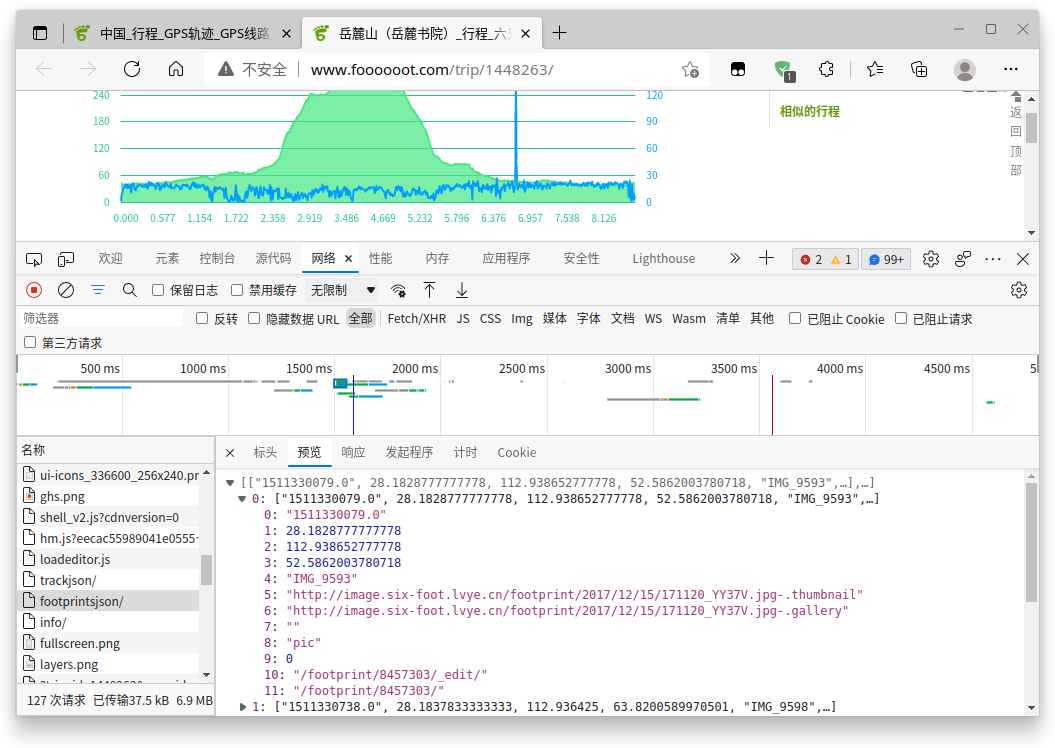

## 3. 数据爬取

经过上面的数据分析，爬取轨迹数据主要就是通过page和keyword构造网址获取轨迹ID，通过轨迹ID构造地址获取trackjson和footprintsjson

笔者此处基于Python，使用requests库发送http请求，使用Xpath解析界面提取数据

### 3.1 引入库

In [1]:
import requests
from lxml import etree
import json
import time

- 注意： 如果缺少相关库，请使用pip或者conda安装

### 3.2 获取所有轨迹ID

In [2]:
page_num = 1
track_num_arr = []
keyword = "岳麓山"
headers = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/65.0.3325.181 Safari/537.36'}
page_url = "http://www.foooooot.com/search/trip/all/1/all/time/descent/?page=" + str(page_num) + "&keyword=" + keyword

* 注意：发起请求请务必设置休眠时间，瞬间的大量访问请求会导致网站崩溃
* 目前此网站设置了简易反爬措施，不设置'user-agent'将 无法访问

In [9]:
next_page = True
while(next_page):
    response = requests.get(page_url,timeout=5, headers=headers)
    tree = etree.HTML(response.text)
    trip_list = tree.xpath('//p[@class="trip-title"]/a/@href')
    if(len(trip_list) == 30):
        page_num = page_num + 1
        page_url = "http://www.foooooot.com/search/trip/all/1/all/time/descent/?page=" + str(page_num) + "&keyword=" + keyword
    else:
        next_page = False
    for trip in trip_list:
        track_num_arr.append(trip.split('/')[2])
    time.sleep(6)

In [10]:
print(len(track_num_arr))

1170


可以看到有1170条轨迹数据

### 3.3 获取轨迹数据

In [37]:
num = 0 
for track_num in track_num_arr:
    try:
        #设置重连次数
        requests.adapters.DEFAULT_RETRIES = 5
        s = requests.session()
        # 设置连接活跃状态为False
        s.keep_alive = False
        time.sleep(6)
        footprint_url = "http://www.foooooot.com/trip/" + str(track_num) + "/footprintsjson/"
        trackjson_url = "http://www.foooooot.com/trip/" + str(track_num) + "/trackjson/"
        footprint_res = requests.get(footprint_url,headers=headers,stream=False,timeout= 10)
        trackjson_res = requests.get(trackjson_url,headers=headers,stream=False,timeout= 10)
        try:
            trackjson = json.loads(trackjson_res.text)
            footprint = json.loads(footprint_res.text)
            with open("./trackdata/origin/trackjson" +  str(track_num) + ".json","w") as tf:
                json.dump(trackjson,tf)
            with open("./trackdata/origin/footprint" +  str(track_num) + ".json","w") as ff:
                json.dump(footprint,ff)
            for track in trackjson:
                with open("./trackdata/trip_" +  str(track_num) + ".txt","a") as tf:
                    tf.write(str(track[1]) + " " + str(track[2]) + " " + str(track[3]) + " " + str(int(track[0])) + "\n")
                with open("./trackdata/all.csv","a") as af:
                    af.write(str(num) + "," + str(track[2]) + "," + str(track[1]) + "," + str(track[3]) + "," + str(track_num) + "," + str(int(track[0])) + "\n")
                    num = num + 1
            # print("DONE: " + track_num)
            # 关闭请求  释放内存
            footprint_res.close()
            trackjson_res.close()
            del(footprint_res)
            del(trackjson_res) 
        except Exception as we:
            print(we)
            print("ERROR: " + track_num)
            with open("./trackdata/error.txt","a") as af:
                af.write(str(track_num) + '\n')
            # 关闭请求  释放内存
            footprint_res.close()
            trackjson_res.close()
            del(footprint_res)
            del(trackjson_res) 
    except Exception as ce:
        print(ce)
        time.sleep(60)

Expecting value: line 1 column 1 (char 0)
ERROR: 3541376
Expecting value: line 1 column 1 (char 0)
ERROR: 3541373
Expecting value: line 1 column 1 (char 0)
ERROR: 3541372
Expecting value: line 1 column 1 (char 0)
ERROR: 3541371
Expecting value: line 1 column 1 (char 0)
ERROR: 3541430
Expecting value: line 1 column 1 (char 0)
ERROR: 3505289
Expecting value: line 1 column 1 (char 0)
ERROR: 5135959
Expecting value: line 1 column 1 (char 0)
ERROR: 3390423
Expecting value: line 1 column 1 (char 0)
ERROR: 3389498
Expecting value: line 1 column 1 (char 0)
ERROR: 3392149
Expecting value: line 1 column 1 (char 0)
ERROR: 3392065
Expecting value: line 1 column 1 (char 0)
ERROR: 3392040


- 笔者遇到过IO错误和连接错误，所以用try except包裹起来，但是两层try总觉得不对劲
- trip_track_num.txt 这个文件写法主要是参考map construction的轨迹文件
- 经笔者验证，`ERROR`的那几个轨迹确实没有数据

## 4. 可视化

在QGIS中利用加载XY文件的方式加载all.csv文件，并设置OSM底图，预览GPS轨迹：

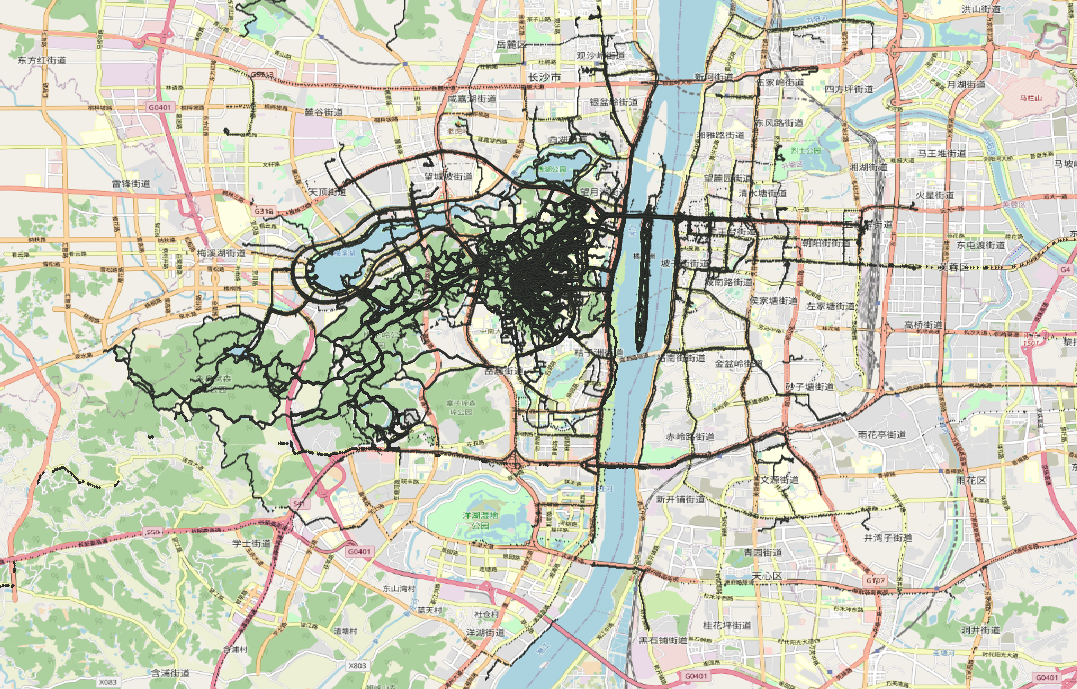